In [1]:
import os

import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import nibabel as nib

from nistats import design_matrix as dm
from bids.layout import BIDSLayout
from scipy.signal import convolve, resample
from nistats import hemodynamic_models
from sklearn.linear_model import Ridge
from sklearn.preprocessing import normalize
from nilearn.input_data import NiftiLabelsMasker
import seaborn as sns

/home/jdkent/.conda/envs/aim1_valid/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/jdkent/.conda/envs/aim1_valid/lib/python3.7/site-packages/duecredit/utils.py:32: DeprecationWarning: dist() and linux_distribution() functions are deprecated in Python 3.5
  and platform.linux_distribution()[0] == 'debian' \
/home/jdkent/.conda/envs/aim1_valid/lib/python3.7/site-packages/duecredit/io.py:18: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import defaultdict, Iterator
/home/jdkent/.conda/envs/aim1_valid/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
/home/jdkent/.conda/envs/aim1_val

In [2]:
# borrowed from:
# https://github.com/achennings/python_deconvolution/blob/master/deconvolve.ipynb?fbclid=IwAR1bpNjAcxZ9x24oZiwsZE_Rcjg-FLuUp1zoJ7vmS_lZCBti-0ITkCJ0RG8
# https://github.com/kbonna/decidenet/blob/master/connectivity_analysis/dn_ca_01_ridge_deconvolution.ipynb
def dct_basis(n, k):
    '''Creates basis functions for Discrete Cosine Transform (DCT).
    
    Args:
        n (int): Number of signal timepoints.
        k (int): Number of basis functions.
        
    Returns:
        Discrete cosine basis set in a matrix form. Shape of the matrix is n x k.
    '''
    X = np.zeros((n, k))
    for i in range(k):
        X[:, i] = np.sqrt(2 / n) * np.cos(np.pi * np.arange(n) * i / n)
    return X


def deconvolve(signal, alpha, X, HX):
    '''Deconvolve signal using ridge regression and cosine basis set.
    
    Uses ridge regression for solving set of correlated linear equations. Ridge regression allows 
    solving matrix equation y=Xb+e introducing regularization parameter. X corresponds to chosen
    basis set (here cosine set convolved with HRF), b is a vector of unknown weights for basis 
    functions and y is modeled signal. Fitted b weights are used to recreate neural signal as linear
    combinations of unconvolved cosines.
    
    Args:
        signal (iterable):
            BOLD signal.
        alpha (float):
            Regularization parameter (lower-bounded by zero).
        X (2-D array):
            Basis functions in neural space (not convolved).
        HX (2-D array):
            Basis functions in BOLD space (convolved with HRF).
        
    Returns:
        Deconvolved BOLD signal in neural space.
    '''
    lin = Ridge(
        alpha=alpha,
        solver='lsqr',
        fit_intercept=False,
        normalize=False,
        max_iter=1000
    )
    lin.fit(HX, signal)
    return np.matmul(X, lin.coef_)


def _select_confounds(confounds_file, selected_confounds):
    """Process and return selected confounds from the confounds file
    Parameters
    ----------
    confounds_file : str
        File that contains all usable confounds
    selected_confounds : list
        List containing all desired confounds.
        confounds can be listed as regular expressions (e.g., "motion_outlier.*")
    Returns
    -------
    desired_confounds : DataFrame
        contains all desired (processed) confounds.
    """
    import pandas as pd
    import numpy as np
    import re

    confounds_df = pd.read_csv(confounds_file, sep='\t', na_values='n/a')
    # regular expression to capture confounds specified at the command line
    confound_expr = re.compile(r"|".join(selected_confounds))
    expanded_confounds = list(filter(confound_expr.fullmatch, confounds_df.columns))
    imputables = ('framewise_displacement', 'std_dvars', 'dvars', '.*derivative1.*')

    # regular expression to capture all imputable confounds
    impute_expr = re.compile(r"|".join(imputables))
    expanded_imputables = list(filter(impute_expr.fullmatch, expanded_confounds))
    for imputable in expanded_imputables:
        vals = confounds_df[imputable].values
        if not np.isnan(vals[0]):
            continue
        # Impute the mean non-zero, non-NaN value
        confounds_df[imputable][0] = np.nanmean(vals[vals != 0])

    desired_confounds = confounds_df[expanded_confounds]
    # check to see if there are any remaining nans
    if desired_confounds.isna().values.any():
        msg = "The selected confounds contain nans: {conf}".format(conf=expanded_confounds)
        raise ValueError(msg)
    return desired_confounds


def get_duplicate_columns(df):
    '''
    Get a list of duplicate columns.
    It will iterate over all the columns in dataframe and find the columns whose contents are duplicate.
    :param df: Dataframe object
    :return: List of columns whose contents are duplicates.
    '''
    duplicateColumnNames = set()
    # Iterate over all the columns in dataframe
    for x in range(df.shape[1]):
        # Select column at xth index.
        col = df.iloc[:, x]
        # Iterate over all the columns in DataFrame from (x+1)th index till end
        for y in range(x + 1, df.shape[1]):
            # Select column at yth index.
            otherCol = df.iloc[:, y]
            # Check if two columns at x 7 y index are equal
            if np.all(np.isclose(col, otherCol)):
                duplicateColumnNames.add(df.columns.values[y])
    return list(duplicateColumnNames)


def convolve_signal(signal, t_r=2, oversampling=50, hrf_model='spm'):
    '''Convolve signal with hemodynamic response function.
    
    Performs signal convolution with requested hrf model. This function wraps around nistats 
    compute_regressor function usually used for creating task-based regressors. The trick is to 
    define neural regressor as a sequence of equally spaced (with the gap of 1TR) and modulated
    'task events'. Event amplitude modulation corresponds to neural signal amplitude at a given 
    timepoint.
    
    Args:
        signal (iterable):
            Neural signal.
        t_r (float):
            Repetition time in seconds.
        oversampling (int, optional):
            Convolution upsampling rate.
        hrf_model (str, optional):
            Hemodynamic response function type. See the documentation of compute regressor function 
            from nistats.hemodynamic_models for more details.
            
    Returns:
        Convolved neural signal in BOLD space.
    '''
    n_volumes = len(signal)
    frame_times = np.arange(0, n_volumes * t_r, t_r)
    onsets = np.zeros((3, n_volumes))
    for vol, amplitude in enumerate(signal):
        onsets[:, vol] = (vol * t_r, 0, amplitude)

    signal_bold = hemodynamic_models.compute_regressor(
        onsets,
        hrf_model=hrf_model,                              
        frame_times=frame_times,
        oversampling=oversampling,     
        fir_delays=None)[0].ravel()

    return signal_bold

In [3]:
# Hardcoded PATHS
BIDS_PATH = '../..'
FMRIPREP_PATH = '../fmriprep'
# DATABASE_PATH = '/home/jdkent/first_level.sqlite'
# DATABASE_PATH = '/home/jdkent/'
FIRST_LEVEL_RESULTS = './outputs/first_level_res.pkl'
SECOND_LEVEL_RESULTS = './outputs/second_level_res.pkl'
# path to bold QA measures
BOLD_QA = '../mriqc/group_bold.tsv'

# OUTPUTS
ATLAS_PATH = '../data/overall_response_atlas.nii.gz'
ATLAS_LUT = '../data/overall_response.tsv'

In [4]:
# layout to get the necessary data files
layout = BIDSLayout(BIDS_PATH,
                    derivatives=FMRIPREP_PATH,
                    # database_path=DATABASE_PATH,
                    #reset_database=False
)

In [5]:
participant = layout.get_subjects()[0]
task = 'taskswitch'

In [6]:
preproc = layout.get(subject=participant,
                 suffix='bold',
                 extension='nii.gz',
                 desc='preproc',
                 space='MNI152NLin2009cAsym',
                 task=task)[0]

confounds_file = layout.get(subject=participant,
                            suffix='regressors',
                            extension='tsv',
                            desc='confounds',
                            task=task,
                            return_type='file')[0]

event_file = layout.get(subject=participant,
                            suffix='events',
                            extension='tsv',
                            task=task,
                            return_type='file')[0]

mask_file = layout.get(suffix='mask',
                        extension='nii.gz',
                        desc='brain',
                        space='MNI152NLin2009cAsym',
                        task=task,
                        subject=participant,
                        return_type='file')[0]

In [7]:
masker = NiftiLabelsMasker(ATLAS_PATH)

In [8]:
# remove all confounds from the timeseries.
confounds = [
    "white_matter",
    "csf",
    "cosine[0-9]{2}",
    "framewise_displacement",
    "non_steady_state_outlier[0-9]{2}",
    "motion_outlier[0-9]{2}"
]
confounds_df = _select_confounds(confounds_file, confounds)
test_ts = masker.fit_transform(preproc.path, confounds=confounds_df.values)

/home/jdkent/.conda/envs/aim1_valid/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
/home/jdkent/.conda/envs/aim1_valid/lib/python3.7/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/home/jdkent/.conda/envs/aim1_valid/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:17: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping, defaultdict


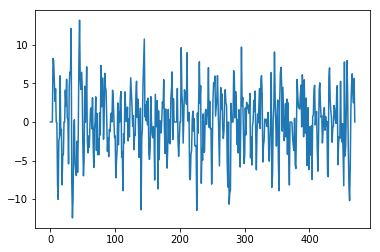

In [9]:
plt.plot(test_ts[:,5])

In [10]:
# create events time series in upsampled space (for the single condition)
events_df = pd.read_csv(event_file, sep='\t')

In [11]:
tr = preproc.get_metadata()['RepetitionTime']


# stim_length = events_df.query("trial_type == 'single'")["duration"].mean()
# onsets = events_df.query("trial_type == 'single'")['onset']

In [12]:
test_ts_upsample.shape

NameError: name 'test_ts_upsample' is not defined

In [ ]:
plt.plot(test_ts_upsample[:,0])

In [ ]:
plt.plot(test_ts[:,0])

In [ ]:
xb = dct_basis(test_ts.shape[0], test_ts.shape[0])

In [ ]:
# 
hrf = np.array(hemodynamic_models._gamma_difference_hrf(tr=(tr / upsample_factor), oversampling=1))
Hxb = np.zeros((test_ts.shape[0], test_ts.shape[0]))
for i in range(test_ts.shape[0]):
    Hx = convolve(xb[:,i], hrf)[:test_ts.shape[0]]
    Hxb[:,i] = Hx
    

HXb2 = np.zeros(xb.shape)
for i, xi in enumerate(xb):
    HXb2[:, i] = convolve_signal(xi)

In [ ]:
plt.figure(figsize=(10,10))
sns.heatmap(HXb2,cmap='mako_r', square=True);

In [ ]:
sns.heatmap(HXb2 cmap='mako_r', square=True);

In [ ]:
regen = convolve_signal(deconvolve(test_ts[:,0], 0.0001, xb, HXb2))

In [ ]:
plt.plot(range(test_ts.shape[0]), test_ts[:,0])
plt.plot(range(test_ts.shape[0]), regen)

# looks reasonable

In [ ]:
# deconvolve to generate ppi
deconvolved_signal = deconvolve(test_ts[:,0], 0.0001, xb, HXb2)

In [ ]:
total_length_seconds = nib.load(preproc_file).shape[-1] * tr
upsample_factor = 10

frame_times = np.linspace(0, total_length_seconds, total_length_seconds * upsample_factor)

decon_signal_upsample = resample(deconvolved_signal, total_length_seconds * upsample_factor)

stim_length = events_df.query("trial_type == 'single'")["duration"].mean()
onsets = events_df.query("trial_type == 'single'")['onset']

In [ ]:
decon_signal_upsample.shape

In [ ]:
stim_length = int(events_df.query("trial_type == 'single'")["duration"].mean() * upsample_factor)
onsets = events_df.query("trial_type == 'single'")['onset'] * upsample_factor
onsets = onsets.astype(int)

In [ ]:
upsampled_events = np.zeros(len(frame_times))

In [ ]:
upsampled_events[onsets.values] = 1
plt.plot(upsampled_events)

In [ ]:
upsampled_events_convolve = convolve(upsampled_events, np.ones(stim_length), mode='same')

In [ ]:
(upsampled_events_convolve == 1).sum()

In [ ]:
(upsampled_events == 1).sum()

In [ ]:
# demean deconvolved signal
decon_signal_upsample_demean = decon_signal_upsample - decon_signal_upsample.mean()

In [ ]:
upsampled_events_convolve_demean = upsampled_events_convolve - upsampled_events_convolve.mean()

In [ ]:
upsampled_events_convolve_demean

In [ ]:
# create ppi in neural signal
ppi_neural = decon_signal_upsample_demean * upsampled_events_convolve_demean

In [ ]:
plt.plot(ppi_neural)

In [ ]:
# downsample data
ppi_neural_downsample = resample(ppi_neural, test_ts.shape[0])

In [ ]:
plt.plot(ppi_neural_downsample)

In [ ]:
ppi_single = convolve_signal(ppi_neural_downsample)

In [ ]:
plt.plot(ppi_single)

In [ ]:
# afni deconvolve command: 3dTfitter -RHS Seed_ts${cc}${sd}.1D -FALTUNG GammaHR.1D
# spm deconvolve